In [2]:
# ===================================================================
# STEP 1: Import Libraries dan Setup
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data (hanya jalankan sekali)
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    pass

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries berhasil diimport!")

✅ Libraries berhasil diimport!


In [10]:
# ===================================================================
# STEP 2: Load dan Eksplorasi Dataset
# ===================================================================

def load_dataset(filename):
    try:
        df = pd.read_excel(filename)
        
        # Standardize column names
        df.columns = ['No', 'Kalimat', 'Aspek', 'Sentimen']
        
        print(f"✅ Dataset berhasil dimuat: {len(df)} baris")
        print(f"📊 Kolom: {list(df.columns)}")
        
        return df
    except FileNotFoundError:
        print(f"❌ File {filename} tidak ditemukan!")
        return None
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return None

# Load dataset
df = load_dataset('2000_Kalimat_Kinerja_Pesantren_Unik.xlsx')  # Ganti dengan nama file Anda

if df is not None:
    # Eksplorasi data
    print("\n📈 EKSPLORASI DATASET:")
    print("="*50)
    print(f"Jumlah data: {len(df)}")
    print(f"Jumlah aspek unik: {df['Aspek'].nunique()}")
    print(f"Jumlah sentimen unik: {df['Sentimen'].nunique()}")
    
    print("\n📊 Distribusi Aspek:")
    print(df['Aspek'].value_counts())
    
    print("\n📊 Distribusi Sentimen:")
    print(df['Sentimen'].value_counts())
    
    print("\n📋 5 Data Teratas:")
    print(df['Kalimat'])
   


✅ Dataset berhasil dimuat: 324 baris
📊 Kolom: ['No', 'Kalimat', 'Aspek', 'Sentimen']

📈 EKSPLORASI DATASET:
Jumlah data: 324
Jumlah aspek unik: 4
Jumlah sentimen unik: 3

📊 Distribusi Aspek:
Aspek
Kualitas Guru          81
Prestasi               81
Kualitas Pengajaran    81
Fasilitas              81
Name: count, dtype: int64

📊 Distribusi Sentimen:
Sentimen
Positif    108
Negatif    108
Netral     108
Name: count, dtype: int64

📋 5 Data Teratas:
0      Pengajar memiliki kompetensi memberikan perhat...
1      Pengalaman guru masih perlu ditingkatkan. Meng...
2      Beberapa guru masih perlu ditingkatkan. Mengur...
3      Prestasi santri meraih prestasi akademik dan n...
4      Proses belajar mengajar sangat efektif dan men...
                             ...                        
319    Materi pelajaran terasa terlalu padat dan suli...
320    Metode pembelajaran cukup baik tapi masih bisa...
321    Proses belajar mengajar sangat efektif dan men...
322    Pengajaran kadang masih perlu 

In [22]:
# ===================================================================
# STEP 3: Load Lexicon Files
# ===================================================================

def load_lexicon(filename, lexicon_type):
    """Load lexicon dengan struktur: word, weight"""
    try:
        lexicon_df = pd.read_csv(filename)
        
        # Standardize column names
        if 'word' not in lexicon_df.columns:
            lexicon_df.columns = ['word', 'weight']
        
        # Convert to lowercase dan buat set untuk pencarian cepat
        words_set = set(lexicon_df['word'].str.lower().tolist())
        weights_dict = dict(zip(lexicon_df['word'].str.lower(), lexicon_df['weight']))
        
        print(f"✅ {lexicon_type} lexicon berhasil dimuat: {len(words_set)} kata")
        return words_set, weights_dict
    
    except FileNotFoundError:
        print(f"❌ File {filename} tidak ditemukan!")
        return set(), {}
    except Exception as e:
        print(f"❌ Error loading {lexicon_type} lexicon: {e}")
        return set(), {}

# Load lexicon files
positive_words, positive_weights = load_lexicon('positive.csv', 'Positive')
negative_words, negative_weights = load_lexicon('negative.csv', 'Negative')

print(f"\n📚 LEXICON SUMMARY:")
print(f"Positive words: {len(positive_words)}")
print(f"Negative words: {len(negative_words)}")
print(positive_words)
print(positive_weights)

✅ Positive lexicon berhasil dimuat: 3607 kata
✅ Negative lexicon berhasil dimuat: 6606 kata

📚 LEXICON SUMMARY:
Positive words: 3607
Negative words: 6606
{'lantik', 'lahir', 'asket', 'mumpung', 'kekeliruan', 'terjamin', 'manila', 'pemaafan', 'gema', 'sains', 'berprakarsa', 'guntang-guntang', 'andai', 'zikir', 'kaya', 'malim', 'selera', 'pancur', 'bopong', 'kebolehan', 'naik pelaminan', 'makruf', 'relasi', 'tabah', 'diam', 'distingtif', 'statistik', 'temennya', 'interpretasi', 'santai', 'layanan', 'rida', 'pagon', 'terbuka mata', 'dukungan', 'ramah', 'berdisiplin', 'naik ke pelaminan', 'kimah', 'kesepakatan', 'berpatroli', 'drastis', 'santunan', 'berkedudukan', 'check', 'hastag', 'minta', 'gari', 'para-para', 'ready', 'terkadang', 'studi', 'sambung tangan', 'tiara', 'emosi', 'berzikir', 'gairah', 'kejelasan', 'latih', 'administrator', 'menokok', 'cuat', 'peri', 'nyana', 'tangguh', 'tlg', 'membatu', 'kenang-kenangan', 'nyala', 'daya pikir', 'bantah-bantah', 'putusan', 'prigel', 'keputusa

In [23]:
# ===================================================================
# STEP 4: Text Preprocessing
# ===================================================================

def preprocess_text(text):
    """Preprocessing teks Indonesia"""
    if pd.isna(text) or text == '':
        return ""
    
    # Convert to string dan lowercase
    text = str(text).lower()
    
    # Remove special characters, numbers, dan extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    
    # Tokenization
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()
    
    # Remove stopwords Indonesia
    try:
        stop_words = set(stopwords.words('indonesian'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    except:
        # Jika NLTK stopwords tidak tersedia, gunakan stopwords manual
        manual_stopwords = {'dan', 'atau', 'yang', 'ini', 'itu', 'dengan', 'untuk', 'dari', 'ke', 'di', 'pada', 'dalam', 'oleh', 'seperti', 'juga', 'akan', 'telah', 'sudah', 'adalah', 'ada', 'tidak', 'bukan', 'saya', 'kami', 'kita', 'mereka', 'dia'}
        tokens = [word for word in tokens if word not in manual_stopwords and len(word) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing
if df is not None:
    print("🔄 Memproses teks...")
    df['Kalimat_Processed'] = df['Kalimat'].apply(preprocess_text)
    
    print("✅ Text preprocessing selesai!")
    print("\n📋 Contoh hasil preprocessing:")
    for i in range(min(3, len(df))):
        print(f"Original: {df.iloc[i]['Kalimat']}")
        print(f"Processed: {df.iloc[i]['Kalimat_Processed']}")
        print("-" * 50)


🔄 Memproses teks...
✅ Text preprocessing selesai!

📋 Contoh hasil preprocessing:
Original: Pengajar memiliki kompetensi memberikan perhatian penuh. Santri merasa didukung.
Processed: pengajar memiliki kompetensi perhatian penuh santri didukung
--------------------------------------------------
Original: Pengalaman guru masih perlu ditingkatkan. Mengurangi kualitas belajar.
Processed: pengalaman guru ditingkatkan mengurangi kualitas belajar
--------------------------------------------------
Original: Beberapa guru masih perlu ditingkatkan. Mengurangi kualitas belajar.
Processed: guru ditingkatkan mengurangi kualitas belajar
--------------------------------------------------


In [24]:
# ===================================================================
# STEP 5: Lexicon-Based Sentiment Analysis
# ===================================================================

def lexicon_sentiment_analysis(text, pos_words, neg_words, pos_weights, neg_weights):
    """Analisis sentimen berbasis lexicon dengan bobot"""
    if not text or text == '':
        return 'netral', 0.0
    
    words = text.lower().split()
    
    positive_score = sum(pos_weights.get(word, 1.0) for word in words if word in pos_words)
    negative_score = sum(neg_weights.get(word, 1.0) for word in words if word in neg_words)
    
    # Hitung confidence score
    total_score = positive_score + negative_score
    confidence = total_score / len(words) if words else 0
    
    if positive_score > negative_score:
        return 'positif', confidence
    elif negative_score > positive_score:
        return 'negatif', confidence
    else:
        return 'netral', confidence

# Apply lexicon-based analysis
if df is not None:
    print("🔄 Melakukan analisis sentimen berbasis lexicon...")
    
    lexicon_results = df['Kalimat_Processed'].apply(
        lambda x: lexicon_sentiment_analysis(x, positive_words, negative_words, 
                                           positive_weights, negative_weights)
    )
    
    df['Lexicon_Sentiment'] = [result[0] for result in lexicon_results]
    df['Lexicon_Confidence'] = [result[1] for result in lexicon_results]
    
    print("✅ Lexicon-based analysis selesai!")
    
    # Compare with actual sentiment
    print("\n📊 Perbandingan Lexicon vs Actual Sentiment:")
    comparison = pd.crosstab(df['Sentimen'], df['Lexicon_Sentiment'])
    print(comparison)


🔄 Melakukan analisis sentimen berbasis lexicon...
✅ Lexicon-based analysis selesai!

📊 Perbandingan Lexicon vs Actual Sentiment:
Lexicon_Sentiment  netral  positif
Sentimen                          
Negatif                 2      106
Netral                  2      106
Positif                 0      108


In [25]:
# ===================================================================
# STEP 6: Prepare Data for RNN
# ===================================================================

class RNNDataPreparator:
    def __init__(self, max_features=5000, max_length=100):
        self.max_features = max_features
        self.max_length = max_length
        self.tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
        self.label_encoder = LabelEncoder()
        self.aspect_encoder = LabelEncoder()
    
    def prepare_data(self, df):
        """Prepare data untuk training RNN"""
        print("🔄 Mempersiapkan data untuk RNN...")
        
        # Remove empty texts
        df_clean = df.dropna(subset=['Kalimat_Processed'])
        df_clean = df_clean[df_clean['Kalimat_Processed'] != '']
        
        # Tokenization
        texts = df_clean['Kalimat_Processed'].tolist()
        self.tokenizer.fit_on_texts(texts)
        sequences = self.tokenizer.texts_to_sequences(texts)
        
        # Padding
        X = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')
        
        # Encode labels
        y_sentiment = self.label_encoder.fit_transform(df_clean['Sentimen'])
        y_aspect = self.aspect_encoder.fit_transform(df_clean['Aspek'])
        
        print(f"✅ Data preparation selesai!")
        print(f"📊 Shape X: {X.shape}")
        print(f"📊 Unique sentiments: {self.label_encoder.classes_}")
        print(f"📊 Unique aspects: {self.aspect_encoder.classes_}")
        print(f"📊 Vocabulary size: {len(self.tokenizer.word_index)}")
        
        return X, y_sentiment, y_aspect, df_clean

# Prepare data
if df is not None:
    preparator = RNNDataPreparator()
    X, y_sentiment, y_aspect, df_clean = preparator.prepare_data(df)


🔄 Mempersiapkan data untuk RNN...
✅ Data preparation selesai!
📊 Shape X: (324, 100)
📊 Unique sentiments: ['Negatif' 'Netral' 'Positif']
📊 Unique aspects: ['Fasilitas' 'Kualitas Guru' 'Kualitas Pengajaran' 'Prestasi']
📊 Vocabulary size: 115


In [26]:
# ===================================================================
# STEP 7: Build RNN Model
# ===================================================================

def build_sentiment_model(vocab_size, embedding_dim=128, lstm_units=64, max_length=100, num_classes=3):
    """Build RNN model untuk sentiment analysis"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        Bidirectional(LSTM(lstm_units//2, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_aspect_model(vocab_size, embedding_dim=128, lstm_units=64, max_length=100, num_classes=5):
    """Build RNN model untuk aspect classification"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        Bidirectional(LSTM(lstm_units//2, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build models
if 'X' in locals():
    vocab_size = min(preparator.max_features, len(preparator.tokenizer.word_index) + 1)
    
    print("🏗️ Building models...")
    
    # Sentiment model
    sentiment_model = build_sentiment_model(
        vocab_size=vocab_size,
        max_length=preparator.max_length,
        num_classes=len(preparator.label_encoder.classes_)
    )
    
    # Aspect model
    aspect_model = build_aspect_model(
        vocab_size=vocab_size,
        max_length=preparator.max_length,
        num_classes=len(preparator.aspect_encoder.classes_)
    )
    
    print("✅ Models berhasil dibuat!")
    print("\n📋 Sentiment Model Summary:")
    sentiment_model.summary()


🏗️ Building models...
✅ Models berhasil dibuat!

📋 Sentiment Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# ===================================================================
# STEP 8: Train Models
# ===================================================================

def train_model(model, X, y, model_name, epochs=10, batch_size=32, validation_split=0.2):
    """Train model dengan early stopping"""
    print(f"🚀 Training {model_name}...")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=validation_split, random_state=42, stratify=y
    )
    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=0.001
    )
    
    # Training
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluation
    y_pred = np.argmax(model.predict(X_val), axis=1)
    
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    
    return history, X_val, y_val, y_pred

# Train models
if 'sentiment_model' in locals():
    print("🎯 TRAINING PHASE")
    print("="*50)
    
    # Train sentiment model
    sentiment_history, X_val_sent, y_val_sent, y_pred_sent = train_model(
        sentiment_model, X, y_sentiment, "Sentiment Model", epochs=15
    )
    
    # Train aspect model
    aspect_history, X_val_asp, y_val_asp, y_pred_asp = train_model(
        aspect_model, X, y_aspect, "Aspect Model", epochs=15
    )


🎯 TRAINING PHASE
🚀 Training Sentiment Model...
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step - accuracy: 0.3634 - loss: 1.1008 - val_accuracy: 0.3231 - val_loss: 1.0974 - learning_rate: 0.0010
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.3373 - loss: 1.0960 - val_accuracy: 0.3231 - val_loss: 1.0932 - learning_rate: 0.0010
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4086 - loss: 1.0857 - val_accuracy: 0.5846 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.3708 - loss: 1.0841 - val_accuracy: 0.6154 - val_loss: 1.0616 - learning_rate: 0.0010
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5020 - loss: 1.0544 - val_accuracy: 0.8154 - val_loss: 0.9958 - learning_rate: 0.0010
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6635 - loss: 0.9700 - val_accuracy: 0.9077 - val_loss: 0.8451 - learning_rate: 0.0010
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - 


📊 EVALUASI SENTIMENT MODEL
Classification Report:
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00        21
      Netral       1.00      1.00      1.00        22
     Positif       1.00      1.00      1.00        22

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



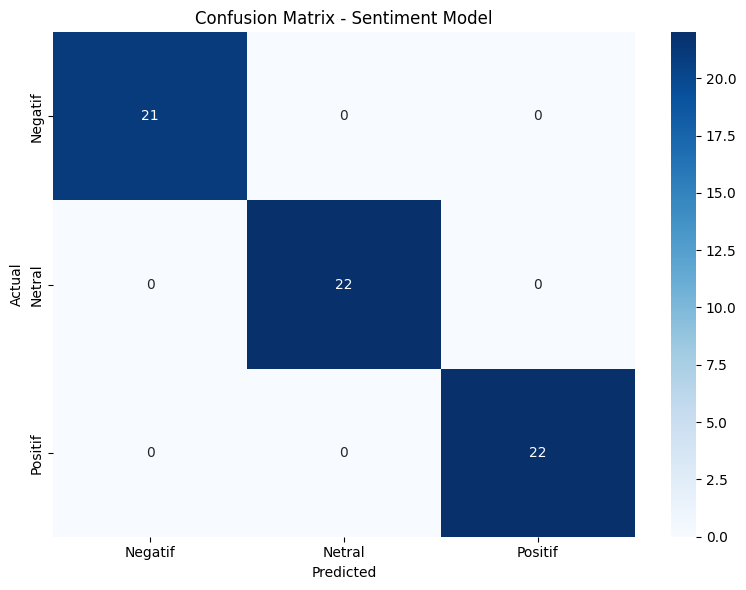


📊 EVALUASI ASPECT MODEL
Classification Report:
                     precision    recall  f1-score   support

          Fasilitas       1.00      1.00      1.00        16
      Kualitas Guru       1.00      1.00      1.00        16
Kualitas Pengajaran       1.00      1.00      1.00        17
           Prestasi       1.00      1.00      1.00        16

           accuracy                           1.00        65
          macro avg       1.00      1.00      1.00        65
       weighted avg       1.00      1.00      1.00        65



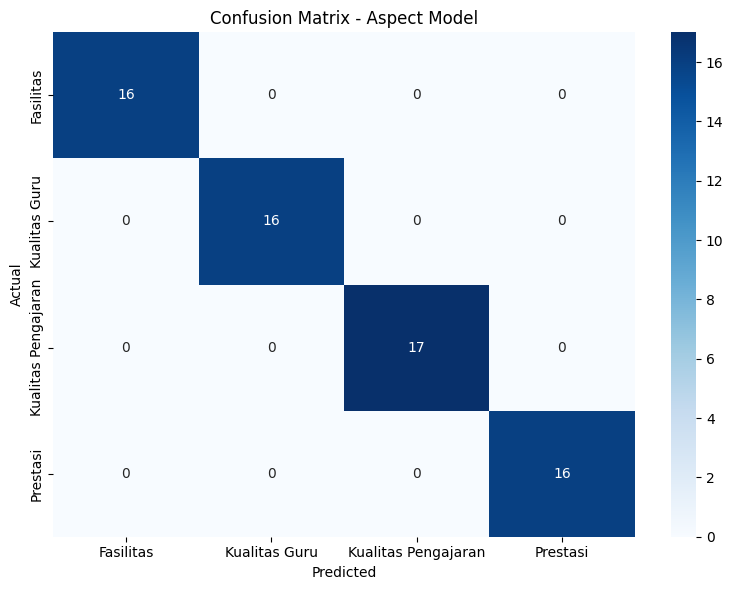

In [28]:
# ===================================================================
# STEP 9: Model Evaluation
# ===================================================================

def evaluate_model(y_true, y_pred, label_encoder, model_name):
    """Evaluasi model dengan classification report dan confusion matrix"""
    print(f"\n📊 EVALUASI {model_name.upper()}")
    print("="*50)
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return cm

# Evaluate models
if 'y_pred_sent' in locals():
    # Evaluate sentiment model
    cm_sentiment = evaluate_model(y_val_sent, y_pred_sent, preparator.label_encoder, "Sentiment Model")
    
    # Evaluate aspect model
    cm_aspect = evaluate_model(y_val_asp, y_pred_asp, preparator.aspect_encoder, "Aspect Model")


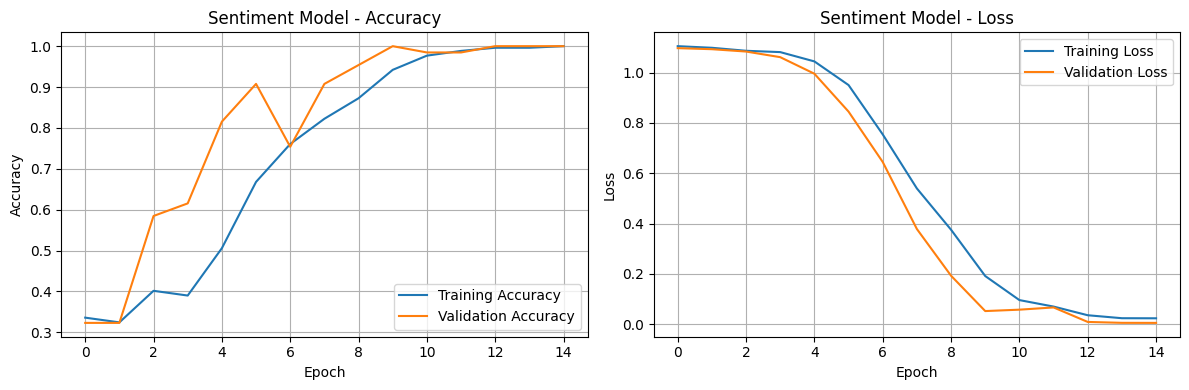

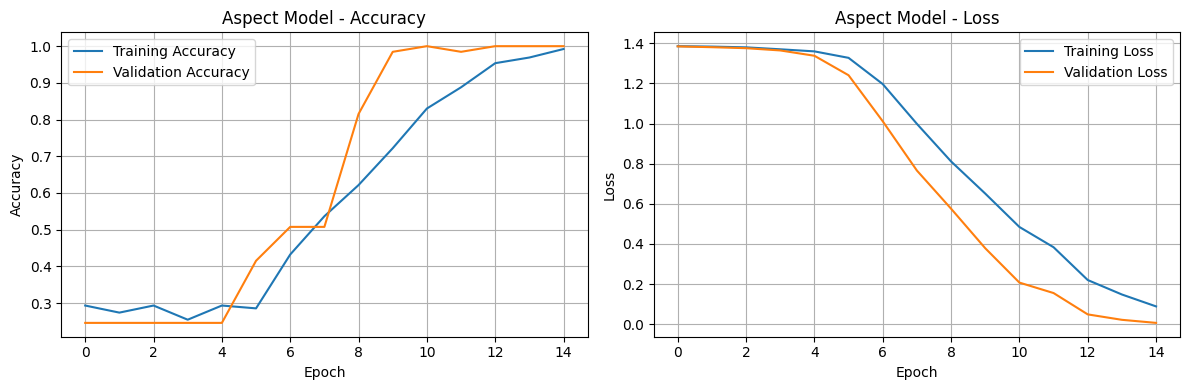

In [29]:
# ===================================================================
# STEP 10: Visualize Training History
# ===================================================================

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training histories
if 'sentiment_history' in locals():
    plot_training_history(sentiment_history, "Sentiment Model")
    plot_training_history(aspect_history, "Aspect Model")

In [30]:
# ===================================================================
# STEP 11: Prediction Function
# ===================================================================

def predict_new_text(text, sentiment_model, aspect_model, preparator, 
                    positive_words, negative_words, positive_weights, negative_weights):
    """Prediksi sentiment dan aspect untuk teks baru"""
    
    # Preprocess text
    processed_text = preprocess_text(text)
    
    if not processed_text:
        return {
            'original_text': text,
            'processed_text': processed_text,
            'rnn_sentiment': 'netral',
            'rnn_aspect': 'unknown',
            'lexicon_sentiment': 'netral',
            'sentiment_confidence': 0.0,
            'aspect_confidence': 0.0
        }
    
    # Tokenize and pad
    sequence = preparator.tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=preparator.max_length)
    
    # RNN Predictions
    sentiment_pred = sentiment_model.predict(padded_sequence, verbose=0)
    aspect_pred = aspect_model.predict(padded_sequence, verbose=0)
    
    # Get predictions
    sentiment_class = np.argmax(sentiment_pred, axis=1)[0]
    aspect_class = np.argmax(aspect_pred, axis=1)[0]
    
    sentiment_confidence = np.max(sentiment_pred)
    aspect_confidence = np.max(aspect_pred)
    
    rnn_sentiment = preparator.label_encoder.inverse_transform([sentiment_class])[0]
    rnn_aspect = preparator.aspect_encoder.inverse_transform([aspect_class])[0]
    
    # Lexicon-based prediction
    lexicon_sentiment, _ = lexicon_sentiment_analysis(
        processed_text, positive_words, negative_words, positive_weights, negative_weights
    )
    
    return {
        'original_text': text,
        'processed_text': processed_text,
        'rnn_sentiment': rnn_sentiment,
        'rnn_aspect': rnn_aspect,
        'lexicon_sentiment': lexicon_sentiment,
        'sentiment_confidence': float(sentiment_confidence),
        'aspect_confidence': float(aspect_confidence)
    }


In [31]:
# ===================================================================
# STEP 12: Test Predictions
# ===================================================================

# Test dengan beberapa contoh
if 'sentiment_model' in locals():
    print("🔮 TESTING PREDICTIONS")
    print("="*50)
    
    test_texts = [
        "Ponpes ini sangat bagus dalam hal pendidikan dan pengajaran ustadznya",
        "Fasilitas asrama kurang bersih dan pelayanan buruk sekali",
        "Biaya pendidikan terjangkau tapi sarana prasarana perlu ditingkatkan",
        "Kegiatan ekstrakurikuler beragam dan sangat menarik untuk santri",
        "Kedisiplinan di ponpes ini sangat ketat dan teratur"
    ]
    
    for i, text in enumerate(test_texts, 1):
        print(f"\n📝 Test {i}:")
        print(f"Text: {text}")
        
        result = predict_new_text(
            text, sentiment_model, aspect_model, preparator,
            positive_words, negative_words, positive_weights, negative_weights
        )
        
        print(f"RNN Sentiment: {result['rnn_sentiment']} (conf: {result['sentiment_confidence']:.3f})")
        print(f"RNN Aspect: {result['rnn_aspect']} (conf: {result['aspect_confidence']:.3f})")
        print(f"Lexicon Sentiment: {result['lexicon_sentiment']}")
        print("-" * 70)


🔮 TESTING PREDICTIONS

📝 Test 1:
Text: Ponpes ini sangat bagus dalam hal pendidikan dan pengajaran ustadznya
RNN Sentiment: Netral (conf: 1.000)
RNN Aspect: Kualitas Guru (conf: 0.927)
Lexicon Sentiment: positif
----------------------------------------------------------------------

📝 Test 2:
Text: Fasilitas asrama kurang bersih dan pelayanan buruk sekali
RNN Sentiment: Netral (conf: 1.000)
RNN Aspect: Kualitas Guru (conf: 0.923)
Lexicon Sentiment: positif
----------------------------------------------------------------------

📝 Test 3:
Text: Biaya pendidikan terjangkau tapi sarana prasarana perlu ditingkatkan
RNN Sentiment: Netral (conf: 1.000)
RNN Aspect: Kualitas Guru (conf: 0.927)
Lexicon Sentiment: positif
----------------------------------------------------------------------

📝 Test 4:
Text: Kegiatan ekstrakurikuler beragam dan sangat menarik untuk santri
RNN Sentiment: Netral (conf: 1.000)
RNN Aspect: Kualitas Guru (conf: 0.927)
Lexicon Sentiment: positif
-----------------------

📊 COMPREHENSIVE DATASET ANALYSIS


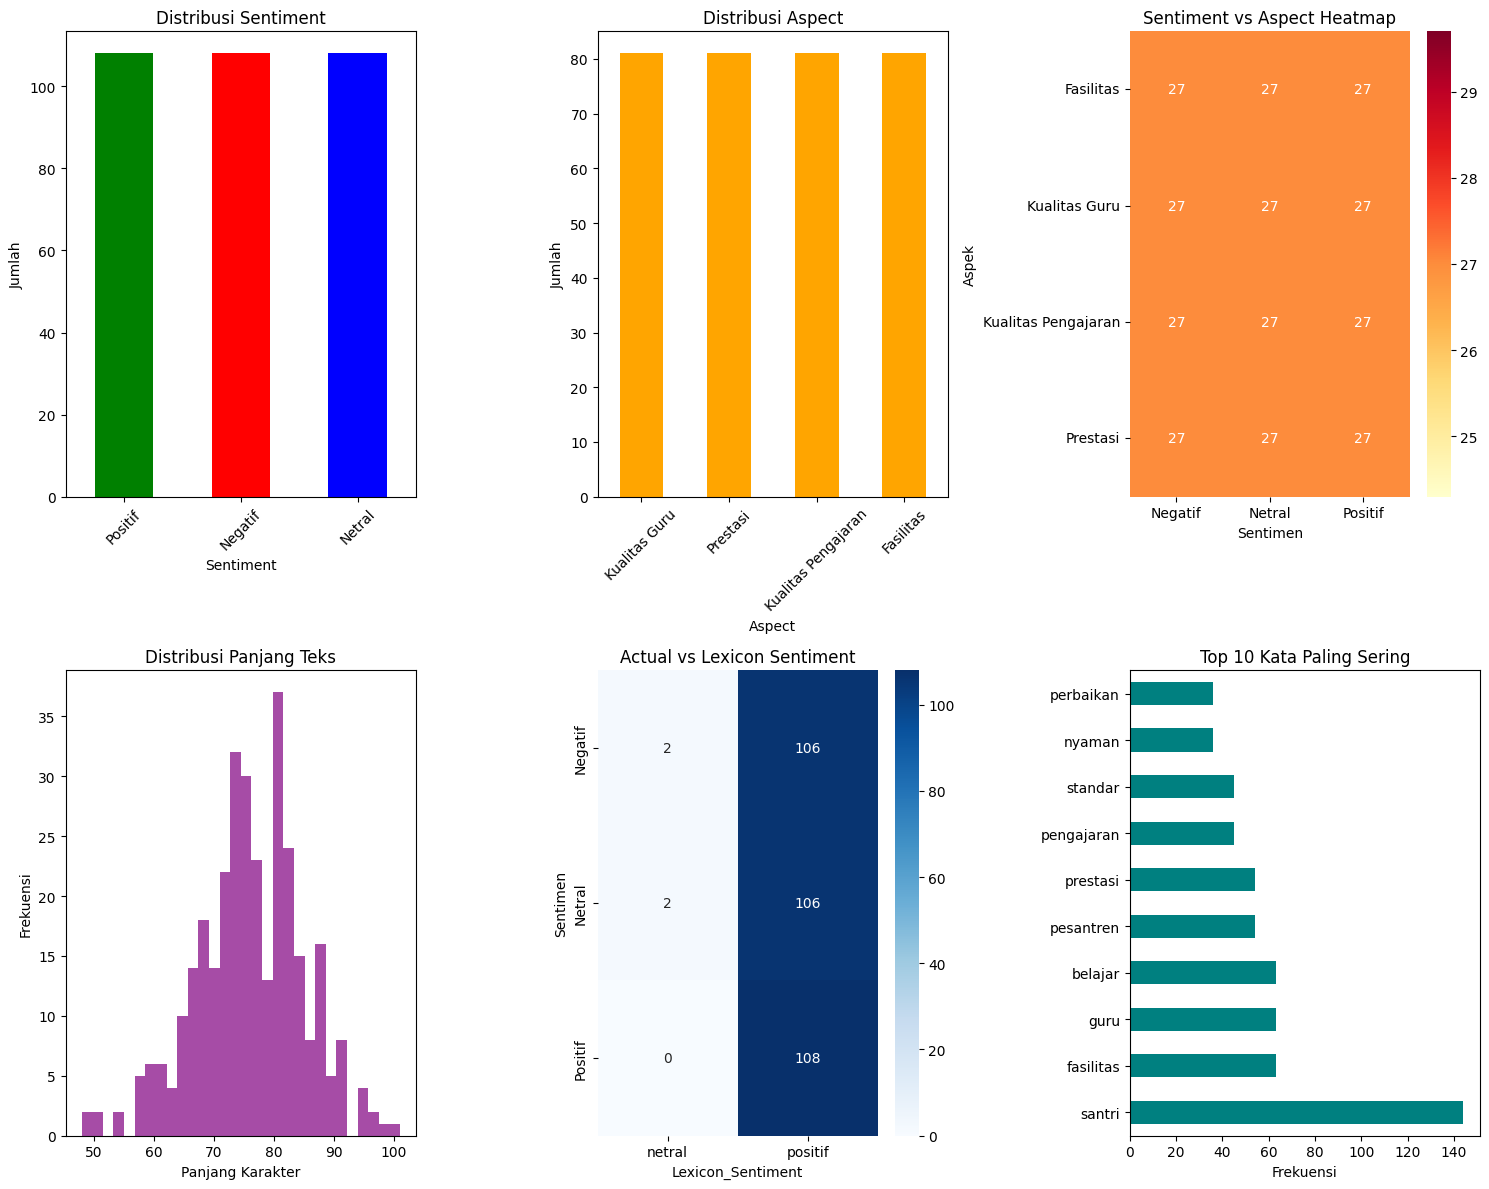


🎉 ANALISIS SELESAI!
📋 Summary:
1. ✅ Dataset berhasil dimuat dan dipreproses
2. ✅ Lexicon-based analysis berhasil dijalankan
3. ✅ RNN models berhasil ditraining
4. ✅ Evaluasi model selesai
5. ✅ Testing predictions berhasil
6. ✅ Comprehensive analysis selesai

🚀 Siap untuk analisis lebih lanjut!


In [32]:
# ===================================================================
# STEP 13: Dataset Analysis & Visualization
# ===================================================================

def create_comprehensive_analysis(df):
    """Analisis komprehensif dataset"""
    
    plt.figure(figsize=(15, 12))
    
    # 1. Distribusi Sentiment
    plt.subplot(2, 3, 1)
    df['Sentimen'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title('Distribusi Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=45)
    
    # 2. Distribusi Aspect
    plt.subplot(2, 3, 2)
    df['Aspek'].value_counts().plot(kind='bar', color='orange')
    plt.title('Distribusi Aspect')
    plt.xlabel('Aspect')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=45)
    
    # 3. Heatmap Sentiment vs Aspect
    plt.subplot(2, 3, 3)
    sentiment_aspect = pd.crosstab(df['Aspek'], df['Sentimen'])
    sns.heatmap(sentiment_aspect, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Sentiment vs Aspect Heatmap')
    
    # 4. Distribusi panjang teks
    plt.subplot(2, 3, 4)
    text_lengths = df['Kalimat'].str.len()
    plt.hist(text_lengths, bins=30, alpha=0.7, color='purple')
    plt.title('Distribusi Panjang Teks')
    plt.xlabel('Panjang Karakter')
    plt.ylabel('Frekuensi')
    
    # 5. Lexicon vs RNN Comparison (jika ada)
    if 'Lexicon_Sentiment' in df.columns:
        plt.subplot(2, 3, 5)
        lexicon_comparison = pd.crosstab(df['Sentimen'], df['Lexicon_Sentiment'])
        sns.heatmap(lexicon_comparison, annot=True, fmt='d', cmap='Blues')
        plt.title('Actual vs Lexicon Sentiment')
    
    # 6. Word cloud atau distribusi kata (placeholder)
    plt.subplot(2, 3, 6)
    all_words = ' '.join(df['Kalimat_Processed'].dropna())
    word_freq = pd.Series(all_words.split()).value_counts().head(10)
    word_freq.plot(kind='barh', color='teal')
    plt.title('Top 10 Kata Paling Sering')
    plt.xlabel('Frekuensi')
    
    plt.tight_layout()
    plt.show()

# Create analysis
if df is not None:
    print("📊 COMPREHENSIVE DATASET ANALYSIS")
    print("="*50)
    create_comprehensive_analysis(df)

print("\n🎉 ANALISIS SELESAI!")
print("="*50)
print("📋 Summary:")
print("1. ✅ Dataset berhasil dimuat dan dipreproses")
print("2. ✅ Lexicon-based analysis berhasil dijalankan")  
print("3. ✅ RNN models berhasil ditraining")
print("4. ✅ Evaluasi model selesai")
print("5. ✅ Testing predictions berhasil")
print("6. ✅ Comprehensive analysis selesai")
print("\n🚀 Siap untuk analisis lebih lanjut!")